In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10)))
# model.add(SimpleRNN(hidden_size, input_shape=(timesteps, input_dim)))
# model.add(SimpleRNN(hidden_size, input_length=M, input_dim=N))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


# 10. 워드 임베딩(Word Embedding)
### 1) 영어 Word2Vec 만들기

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f0c4ec1c510>)

In [ ]:
# 훈련 데이터 전처리
targetXML = open('ted_en-20160408.xml', 'r', encoding='utf-8')
target_text = etree.parse(targetXML)

parse_text = '\n'.join(target_text.xpath('//content/text()'))

content_text =re.sub(r'\([^)]*\)', '', parse_text)
sent_text = sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
print('총 샘플 수 : {}'.format(len(result)))

총 샘플 수 : 273424


In [ ]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### - Word2Vec 훈련시키기

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

# size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
# window = 컨텍스트 윈도우 크기
# min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
# workers = 학습을 위한 프로세스 수
# sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
# Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원한다.

model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8441935181617737), ('guy', 0.8224888443946838), ('boy', 0.7669707536697388), ('girl', 0.7566667199134827), ('lady', 0.7472554445266724), ('gentleman', 0.7385295033454895), ('poet', 0.7173836827278137), ('kid', 0.7116258144378662), ('soldier', 0.6919503211975098), ('friend', 0.6820288896560669)]


In [ ]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') #모델 저장

# loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 저장된 모델 불러오기

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2021-04-08 07:30:44,857 - word2vec2tensor - INFO - running /usr/local/lib/python3.7/dist-packages/gensim/scripts/word2vec2tensor.py --input eng_w2v --output eng_w2v
2021-04-08 07:30:44,858 - utils_any2vec - INFO - loading projection weights from eng_w2v
2021-04-08 07:30:47,147 - utils_any2vec - INFO - loaded (21613, 100) matrix from eng_w2v
2021-04-08 07:30:49,145 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2021-04-08 07:30:49,145 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2021-04-08 07:30:49,148 - word2vec2tensor - INFO - finished running word2vec2tensor.py


### 2) 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4MB 1.6MB/s 
     |████████████████████████████████| 460kB 31.1MB/s 
     |████████████████████████████████| 92kB 6.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f999d52f150>)

In [ ]:
train_data = pd.read_table('ratings.txt')
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
print(len(train_data))

200000


In [ ]:
print(train_data.isnull().values.any()) # NULL 값 존재 유무

True


In [ ]:
train_data = train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data))

199992


In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
train_data[:5] #띄어쓰기가 사라짐...

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt =Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

리뷰 최대 길이:  68
리뷰의 평균 길이 : 10.669446777871116


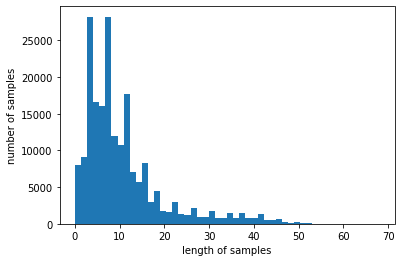

In [ ]:
print('리뷰 최대 길이: ', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(17947, 100)

In [ ]:
print(model.wv.most_similar("최민식"))

[('양동근', 0.8718291521072388), ('안성기', 0.8718253374099731), ('정재영', 0.8522905111312866), ('채민서', 0.8490892648696899), ('단역', 0.8430312871932983), ('윤제문', 0.8410438895225525), ('류덕환', 0.8403877019882202), ('한석규', 0.8399507999420166), ('서영희', 0.8391263484954834), ('김승우', 0.8350732922554016)]


### 3) 케라스 임베딩 층(Keras Embedding layer) 불러와 사용하기

In [ ]:
from keras.layers import Embedding
# 케라스의 임베딩 층 구현
v = Embedding(20000, 128, input_length=500)
# vocab_size : 텍스트 데이터의 전체 단어 집합의 크기
# output_dim : 워드 임베딩 후의 임베딩 벡터의 차원
# input_length : 입력 시퀀스의 길이, 만약 갖고있는 각 샘플의 길이가 500개의 단어로 구성되어있다면 이 값은 500

In [ ]:
v

In [ ]:
#문장의 긍, 부정을 판단하는 감성 분류 모델을 만들어 보자.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent work', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1] #긍정인 문장은 레이블 1, 부정인 문장은 레이블이 0

In [ ]:
t = Tokenizer()
t.fit_on_texts(sentences) #케라스의 Tokenizer()를 사용하여 토큰화 진행
vocab_size = len(t.word_index)+1
# t.word_index : 각 단어에 대한 정수값 부여(1~15)
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언

print(vocab_size)

16


In [ ]:
x_encoded = t.texts_to_sequences(sentences)
print(x_encoded)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [ ]:
max_len=max(len(l) for l in x_encoded)
# 가장 긴 문장을 기준으로 길이 정하기
print(max_len)

4


In [ ]:
x_train = pad_sequences(x_encoded, maxlen=max_len, padding='post')
# 가장 긴문장을 기준으로 나머지는 0으로 채우는 패딩

y_train=np.array(y_train)
print(x_train)
print(y_train)

[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]
[1 0 0 1 1 0 1]


In [ ]:
# 모델 설계

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 4, input_length=max_len))
model.add(Flatten()) # 플래튼(Flatten) 레이어는 인풋의 차원을 풀어 일렬화 한다. # Dense의 입력으로 넣기위함.
# https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
model.add(Dense(1, activation='sigmoid'))
# 출력층에 1개의 뉴런에 활성화 함수로는 시그모이드 함수를 사용하여 이진 분류를 수행

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train, y_train, epochs=100, verbose=2)
# 각 단어들의 임베딩 벡터들의 값은 학습 과정에서 다른 가중치들과 함께 학습된 값이다.

### 4) 사전 훈련된 워드 임베딩(Pre-Trained Word Embedding) 사용하기

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

'''
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt
  inflating: glove.6B.100d.txt
  inflating: glove.6B.200d.txt
  inflating: glove.6B.300d.txt '''

In [ ]:
# glove.6B.100d.txt 파일에는 하나의 줄당 101개의 값을 가지는 리스트를 갖고 있다.
n = 0
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    print(word_vector) # 각 줄을 출력
    word = word_vector[0]
    print(word) # word_vector의 첫번째 값만 출력
    n = n+1
    if n==10:
        break
f.close()

In [ ]:
print(type(word_vector))
print(len(word_vector))

<class 'list'>
101


In [ ]:
# glove.6B.100d.txt에 있는 모든 임베딩 벡터들을 불러와 키(key)와 값(value)의 쌍(pair) 구조로 저장하기

embedding_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr #임베딩 벡터가 의미하는 단어들을 모아놓음
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
# 임의의 단어 excellent의 임베딩 벡터 값 출력
print(embedding_dict['excellent'])
print(len(embedding_dict['excellent']))

[-0.2816     0.18427   -0.06755    0.27694   -0.066775  -0.41389
  0.30757   -0.11097   -0.84585   -0.17047    0.0062422 -0.65395
  0.28771   -0.12409   -0.26717    0.026893   0.17115   -0.46256
  0.19549    1.1399    -0.46206    0.39222   -0.18622   -0.53259
  0.073297   0.0045262 -0.45476    0.16952   -0.41111   -0.31766
 -0.73616    0.56228   -0.26528   -0.088054   0.93175    0.46633
 -0.36245    0.46954   -0.18022   -0.07036    0.55793    0.13965
  0.38983   -0.04636    0.55198    0.020288   0.34741   -0.61839
  0.051404  -0.83699    0.05628   -0.24738   -0.19872    0.75093
  0.068948  -1.7575     0.70621    0.079792   1.1462    -0.63423
 -0.68378    0.51682   -0.68141    0.29451    0.25864   -0.25839
  0.36467    0.026786   0.35151   -0.13273    0.18513    0.52367
  1.0416    -0.12293    0.77957    0.41305   -0.28948    0.19722
  0.41088   -0.35153    0.48837    0.58854   -0.37273   -0.45631
 -0.98976   -0.070993   0.48845   -0.082542  -0.49009   -0.29484
  0.031072  -0.38779    0

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
# vocab_size는 앞서 정의한 15+1이다.
np.shape(embedding_matrix)

(16, 100)

In [ ]:
print(t.word_index.items())
# t.word_index는 각 단어에 대한 정수값 부여(1~15)한 것

dict_items([('nice', 1), ('great', 2), ('best', 3), ('amazing', 4), ('stop', 5), ('lies', 6), ('pitiful', 7), ('nerd', 8), ('excellent', 9), ('work', 10), ('supreme', 11), ('quality', 12), ('bad', 13), ('highly', 14), ('respectable', 15)])


In [ ]:
for word, i in t.word_index.items():
    temp = embedding_dict.get(word)  # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

In [ ]:
temp

array([-0.049773 ,  0.19903  ,  0.10585  ,  0.1391   , -0.32395  ,
        0.44053  ,  0.3947   , -0.22805  , -0.25793  ,  0.49768  ,
        0.15384  , -0.08831  ,  0.0782   , -0.8299   , -0.037788 ,
        0.16772  , -0.45197  , -0.17085  ,  0.74756  ,  0.98256  ,
        0.81872  ,  0.28507  ,  0.16178  , -0.48626  , -0.006265 ,
       -0.92469  , -0.30625  , -0.067318 , -0.046762 , -0.76291  ,
       -0.0025264, -0.018795 ,  0.12882  , -0.52457  ,  0.3586   ,
        0.43119  , -0.89477  , -0.057421 , -0.53724  ,  0.25587  ,
        0.55195  ,  0.44698  , -0.24252  ,  0.29946  ,  0.25776  ,
       -0.8717   ,  0.68426  , -0.05688  , -0.1848   , -0.59352  ,
       -0.11227  , -0.57692  , -0.013593 ,  0.18488  , -0.32507  ,
       -0.90171  ,  0.17672  ,  0.075601 ,  0.54896  , -0.21488  ,
       -0.54018  , -0.45882  , -0.79536  ,  0.26331  ,  0.18879  ,
       -0.16363  ,  0.3975   ,  0.1099   ,  0.1164   , -0.083499 ,
        0.50159  ,  0.35802  ,  0.25677  ,  0.088546 ,  0.4210

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18554001,  0.047152  ,  0.34867001, ...,  0.095473  ,
        -0.1142    ,  0.32743001],
       [-0.013786  ,  0.38216001,  0.53236002, ..., -1.04260004,
         0.28854999,  0.63055998],
       ...,
       [ 0.39456001, -0.24717   ,  1.03190005, ...,  0.0064973 ,
         0.13793001, -0.06832   ],
       [-0.90626001,  0.11363   , -0.050354  , ..., -0.89670998,
        -0.059254  , -0.058493  ],
       [-0.049773  ,  0.19903   ,  0.10585   , ..., -0.19187   ,
        -0.032502  ,  0.38025001]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)

# 사전 훈련된 워드 임베딩을 100차원의 값인 것으로 사용하고 있기 때문에 임베딩 층의 output_dim의 인자값으로 100을 주어야 한다.
# 사전 훈련된 워드 임베딩을 그대로 사용할 것이므로, trainable=False로 별도로 더 이상 훈련을 하지 않는다는 옵션을 설정한다.

In [ ]:
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.6344 - acc: 0.7143
Epoch 2/100
1/1 - 0s - loss: 0.6171 - acc: 0.7143
Epoch 3/100
1/1 - 0s - loss: 0.6003 - acc: 0.7143
Epoch 4/100
1/1 - 0s - loss: 0.5841 - acc: 0.7143
Epoch 5/100
1/1 - 0s - loss: 0.5684 - acc: 0.7143
Epoch 6/100
1/1 - 0s - loss: 0.5532 - acc: 0.7143
Epoch 7/100
1/1 - 0s - loss: 0.5386 - acc: 0.7143
Epoch 8/100
1/1 - 0s - loss: 0.5244 - acc: 0.7143
Epoch 9/100
1/1 - 0s - loss: 0.5107 - acc: 0.7143
Epoch 10/100
1/1 - 0s - loss: 0.4975 - acc: 0.7143
Epoch 11/100
1/1 - 0s - loss: 0.4847 - acc: 0.8571
Epoch 12/100
1/1 - 0s - loss: 0.4723 - acc: 0.8571
Epoch 13/100
1/1 - 0s - loss: 0.4604 - acc: 0.8571
Epoch 14/100
1/1 - 0s - loss: 0.4488 - acc: 0.8571
Epoch 15/100
1/1 - 0s - loss: 0.4376 - acc: 0.8571
Epoch 16/100
1/1 - 0s - loss: 0.4268 - acc: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.4163 - acc: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.4062 - acc: 1.0000
Epoch 19/100
1/1 - 0s - loss: 0.3963 - acc: 1.0000
Epoch 20/100
1/1 - 0s - loss: 0.3868 - a

- 사전 훈련된 Word2Vec 사용하기


In [ ]:
import numpy as np
import gensim

In [ ]:
# 현재 위치에 구글의 사전 훈련된 Word2Vec을 다운로드
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-08 06:58:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.86.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.86.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  71.0MB/s    in 24s     

2021-04-08 06:59:08 (65.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# 구글의 사전 훈련된 Word2vec 모델을 로드
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))

np.shape(embedding_matrix)

(16, 300)

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, i in t.word_index.items():
    # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word)
    # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp
        # 해당 단어 위치의 행에 벡터의 값을 저장한다.

print(word2vec_model['excellent'])

[-2.12890625e-01 -4.30297852e-03 -1.80664062e-01 -7.56835938e-03
  1.12792969e-01  1.63085938e-01 -1.47094727e-02 -7.86132812e-02
 -1.64062500e-01  2.79296875e-01 -2.22656250e-01 -1.37329102e-02
  1.45507812e-01 -4.56542969e-02  5.85937500e-02  1.85546875e-01
  1.13769531e-01  1.13769531e-01 -1.46484375e-01 -1.25122070e-02
  8.78906250e-02  1.44531250e-01 -6.88476562e-02  1.68945312e-01
  2.02148438e-01  3.64685059e-03 -1.24023438e-01  1.76757812e-01
 -4.24804688e-02 -3.54003906e-03  4.93164062e-02 -1.74804688e-01
  2.53906250e-01  1.32812500e-01  2.63671875e-01  2.87109375e-01
 -1.98242188e-01 -9.81445312e-02 -1.18652344e-01 -1.43554688e-01
  3.08593750e-01 -8.93554688e-02 -7.17163086e-03  3.46679688e-02
 -7.86132812e-02 -1.50390625e-01  2.15820312e-01 -1.17675781e-01
  2.85644531e-02 -2.41210938e-01  1.22558594e-01  1.28906250e-01
 -9.27734375e-02  1.16210938e-01  3.29589844e-02  6.49414062e-02
 -8.20312500e-02 -1.60156250e-01  2.00195312e-01 -2.68554688e-02
 -1.57226562e-01  1.26953

In [ ]:
print('단어 excellent의 정수 인덱스: ', t.word_index['excellent'])

단어 excellent의 정수 인덱스:  9


In [ ]:
# 9의 값을 가지므로 embedding_matirx의 1번 인덱스에는 단어 'excellent'의 임베딩 벡터값이 있어야 한다.
print(embedding_matrix[9])

[-2.12890625e-01 -4.30297852e-03 -1.80664062e-01 -7.56835938e-03
  1.12792969e-01  1.63085938e-01 -1.47094727e-02 -7.86132812e-02
 -1.64062500e-01  2.79296875e-01 -2.22656250e-01 -1.37329102e-02
  1.45507812e-01 -4.56542969e-02  5.85937500e-02  1.85546875e-01
  1.13769531e-01  1.13769531e-01 -1.46484375e-01 -1.25122070e-02
  8.78906250e-02  1.44531250e-01 -6.88476562e-02  1.68945312e-01
  2.02148438e-01  3.64685059e-03 -1.24023438e-01  1.76757812e-01
 -4.24804688e-02 -3.54003906e-03  4.93164062e-02 -1.74804688e-01
  2.53906250e-01  1.32812500e-01  2.63671875e-01  2.87109375e-01
 -1.98242188e-01 -9.81445312e-02 -1.18652344e-01 -1.43554688e-01
  3.08593750e-01 -8.93554688e-02 -7.17163086e-03  3.46679688e-02
 -7.86132812e-02 -1.50390625e-01  2.15820312e-01 -1.17675781e-01
  2.85644531e-02 -2.41210938e-01  1.22558594e-01  1.28906250e-01
 -9.27734375e-02  1.16210938e-01  3.29589844e-02  6.49414062e-02
 -8.20312500e-02 -1.60156250e-01  2.00195312e-01 -2.68554688e-02
 -1.57226562e-01  1.26953

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.7170 - acc: 0.4286
Epoch 2/100
1/1 - 0s - loss: 0.6976 - acc: 0.5714
Epoch 3/100
1/1 - 0s - loss: 0.6788 - acc: 0.7143
Epoch 4/100
1/1 - 0s - loss: 0.6605 - acc: 0.8571
Epoch 5/100
1/1 - 0s - loss: 0.6427 - acc: 0.8571
Epoch 6/100
1/1 - 0s - loss: 0.6256 - acc: 0.8571
Epoch 7/100
1/1 - 0s - loss: 0.6090 - acc: 0.8571
Epoch 8/100
1/1 - 0s - loss: 0.5929 - acc: 0.8571
Epoch 9/100
1/1 - 0s - loss: 0.5774 - acc: 0.8571
Epoch 10/100
1/1 - 0s - loss: 0.5624 - acc: 1.0000
Epoch 11/100
1/1 - 0s - loss: 0.5479 - acc: 1.0000
Epoch 12/100
1/1 - 0s - loss: 0.5340 - acc: 1.0000
Epoch 13/100
1/1 - 0s - loss: 0.5205 - acc: 1.0000
Epoch 14/100
1/1 - 0s - loss: 0.5075 - acc: 1.0000
Epoch 15/100
1/1 - 0s - loss: 0.4949 - acc: 1.0000
Epoch 16/100
1/1 - 0s - loss: 0.4828 - acc: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.4711 - acc: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.4598 - acc: 1.0000
Epoch 19/100
1/1 - 0s - loss: 0.4489 - acc: 1.0000
Epoch 20/100
1/1 - 0s - loss: 0.4383 - a

In [ ]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('cc.ko.300.bin')

for w, sim in m_fasttext.similar_by_word('파이썬', 10):
    print(f'{w}: {sim}')